# Submission Nicolo Lüscher

In [478]:
# import libraries
from skimage import io, color, feature, transform
from skimage.filters import gaussian, threshold_otsu
from skimage.morphology import dilation, square
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import os

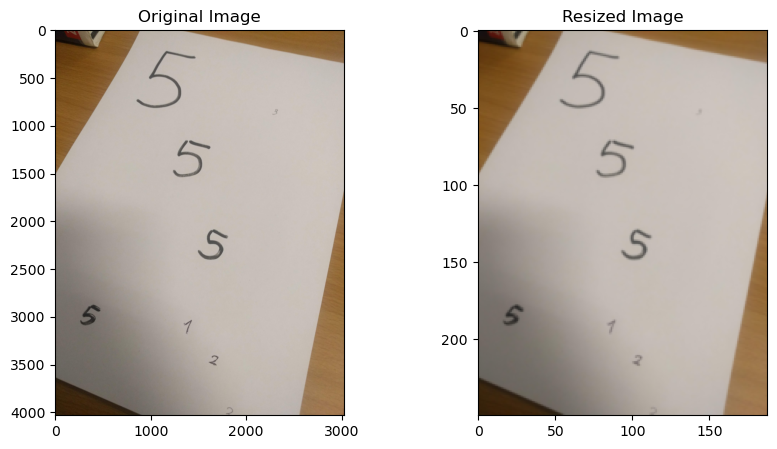

In [479]:
# load image
full_image = io.imread("./images/homework images vol 1/" + os.listdir("./images/homework images vol 1/")[2])
dest_size = 250


# resize image
reduced_image = transform.resize(full_image, (dest_size, dest_size*(full_image.shape[1]/full_image.shape[0])), anti_aliasing=True)

# plotting
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(full_image)
ax[1].imshow(reduced_image)
ax[0].set_title('Original Image')
ax[1].set_title('Resized Image')
plt.show()

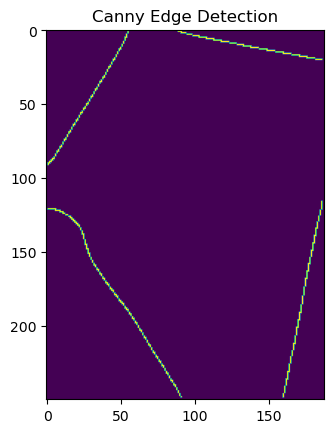

In [480]:
# convert to grayscale
gray_image = color.rgb2gray(reduced_image)
blurred_image = gaussian(gray_image, sigma=5)

# threshold image
thresh = threshold_otsu(blurred_image)
binary_image = blurred_image > thresh

# dilate image
imedges = feature.canny(binary_image, sigma=1)

# plotting
plt.title('Canny Edge Detection')
plt.imshow(imedges)
plt.show()

Line 0: d = 205.0, theta = 11.0
Line 1: d = 49.0, theta = 31.0
Line 2: d = -54.0, theta = -32.0
Line 3: d = 15.0, theta = -79.0


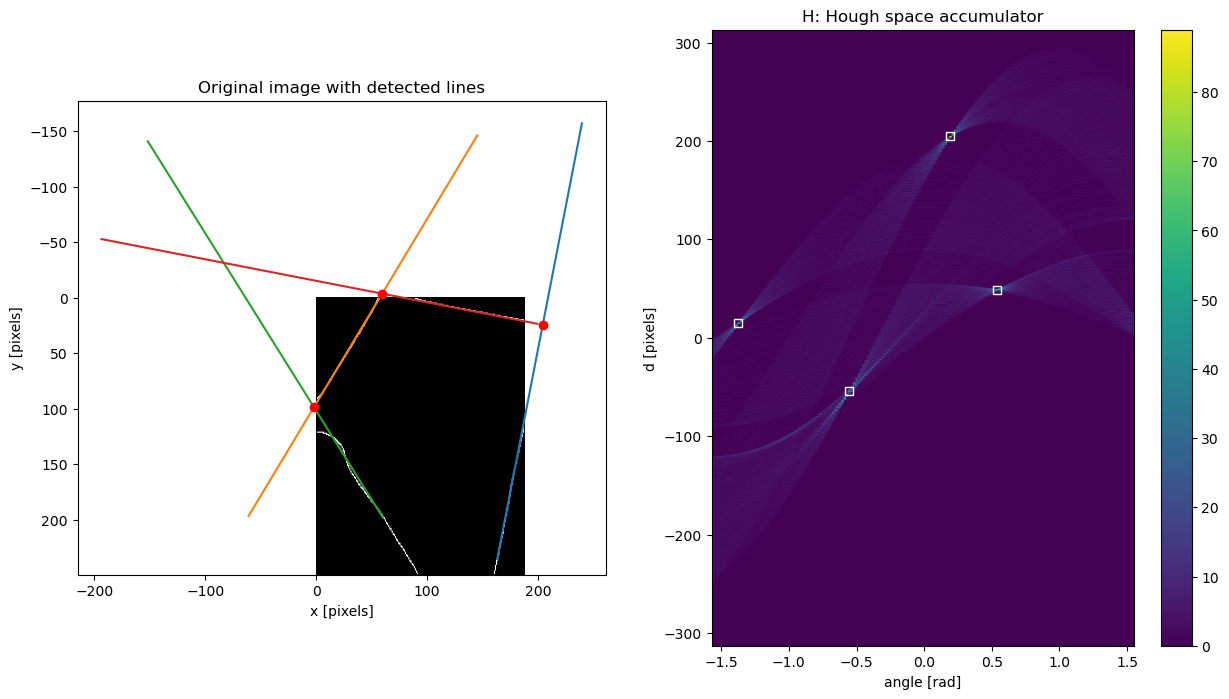

In [484]:
# perform Hough transform
H, angles, distances = transform.hough_line(imedges)

# find the indices of the top 20 highest values in H
k = 35
flattened_indices = np.argpartition(H.ravel(), -k)[-k:]
indices_2D = np.unravel_index(flattened_indices, H.shape)

# extract and sort the corresponding distances and angles
distances_max = distances[indices_2D[0]]
angles_max = angles[indices_2D[1]]
sorted_indices = np.argsort(H[indices_2D])[::-1]
distances_max = distances_max[sorted_indices]
angles_max = angles_max[sorted_indices]

# initialize lists to store accepted distances and angles
accepted_distances = []
accepted_angles = []

# set thresholds for filtering lines
distance_threshold = 50  # pixels
angle_threshold = 0.4  # radians

# plotting
fig, (ax0, ax1) = plt.subplots(ncols=2, nrows=1, figsize=(15, 8))
ax0.set(xlabel="x [pixels]", ylabel="y [pixels]", title="Original image with detected lines")
ax0.imshow(imedges, cmap="gray")
Himage = ax1.imshow(H, extent=(angles[0], angles[-1], distances[0], distances[-1]), origin="lower", aspect="auto")
ax1.set(xlabel="angle [rad]", ylabel="d [pixels]", title="H: Hough space accumulator")
plt.colorbar(Himage)

# loop through the sorted highest values and filter lines
for i in range(k):
    d = distances_max[i]
    theta = angles_max[i]
    
    # check if the line is too close or parallel to already accepted lines
    if len(accepted_distances) > 0:
        distances_diff = np.abs(np.abs(d) - np.abs(np.array(accepted_distances)))
        angles_diff = [np.arccos(np.cos(theta - accepted_theta)) for accepted_theta in accepted_angles]
        if any((distances_diff < distance_threshold) & ((np.array(angles_diff) < angle_threshold) | (np.array(angles_diff) > np.pi - angle_threshold))):
            continue
    
    # add the line to the list of accepted lines
    accepted_distances.append(d)
    accepted_angles.append(theta)
    
    # plot a white rectangle over the maximum in Hough space
    ax1.plot(theta, d, "ws", fillstyle="none")
    
    # draw the line in image space
    p1 = np.array([d * np.cos(theta), d * np.sin(theta)])
    linedir = np.array([np.cos(theta + np.pi / 2), np.sin(theta + np.pi / 2)])
    p0 = p1 - linedir * 200
    p2 = p1 + linedir * 200
    ax0.plot([p0[0], p2[0]], [p0[1], p2[1]], scalex=False, scaley=False)

for i in range(len(accepted_distances)):
    print("Line {}: d = {:.1f}, theta = {:.1f}".format(i, accepted_distances[i], accepted_angles[i] * 180 / np.pi))

# initialize list to store intersection points
intersections = []

# loop through all pairs of lines to find intersections
for i in range(len(accepted_distances)):
    for j in range(i + 1, len(accepted_distances)):
        d1, theta1 = accepted_distances[i], accepted_angles[i]
        d2, theta2 = accepted_distances[j], accepted_angles[j]
        
        # direction vectors
        dir1 = np.array([np.cos(theta1 + np.pi / 2), np.sin(theta1 + np.pi / 2)])
        dir2 = np.array([np.cos(theta2 + np.pi / 2), np.sin(theta2 + np.pi / 2)])
        
        # points on the lines
        p1 = np.array([d1 * np.cos(theta1), d1 * np.sin(theta1)])
        p2 = np.array([d2 * np.cos(theta2), d2 * np.sin(theta2)])
        
        # Solve for intersection
        A = np.vstack([dir1, -dir2]).T
        b = p2 - p1
        if np.linalg.matrix_rank(A) == 2:  # lines are not parallel
            t, s = np.linalg.solve(A, b)
            intersection = p1 + t * dir1
            intersections.append(intersection)

# get the dimensions of the image
height, width = imedges.shape

# filter intersections that are within the image dimensions
intersections = [point for point in intersections if -80 <= point[0] < width+80 and -80 <= point[1] < height+80]

# plot intersections on the image
for intersection in intersections:
    ax0.plot(intersection[0], intersection[1], 'ro')
plt.show()

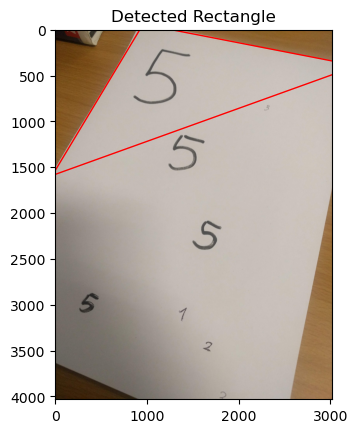

In [482]:
# create figure and axes
fig, ax = plt.subplots(1)

# rescale points to match the original image
intersections = np.array(intersections) * (full_image.shape[0] / dest_size)

# display the image
ax.imshow(full_image)

# calculate the centroid
centroid = np.mean(intersections, axis=0)

# sort the points based on the angle with the centroid
sorted_points = sorted(intersections, key=lambda point: -np.arctan2(point[1] - centroid[1], point[0] - centroid[0]))

# create a rectangle patch
rect = patches.Polygon(sorted_points, closed=True, edgecolor='r', facecolor='none')

# add the patch to the axes
ax.add_patch(rect)

# plotting
ax.set_title('Detected Rectangle')
plt.show()

In [483]:
a, b, c, d = sorted_points[:4]
w,h = 210 * 2,297 * 2 # we assume 10 pixels per mm
A = np.array([0,h])
B = np.array([w,h])
C = np.array([w,0])
D = np.array([0,0])
invtf = transform.estimate_transform(
    "projective", src=np.vstack((A, B, C, D)), dst=np.vstack((a, b, c, d))
)
warped = transform.warp(full_image, inverse_map=invtf, output_shape=(h, w))
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 8))
ax1.imshow(warped)
ax2.imshow(transform.resize(warped, (210*2, 297*2)))
plt.show()

ValueError: not enough values to unpack (expected 4, got 3)